# Kaggle Data Analysis - Suicide Rate Study
### Author: Pau Blasco Roca
### NIU: 1600959


The objective of our study is to analyze the relationships between suicides and other socioeconomic factors accross different countries in Europe (continent). To keep the study in a reasonable scope, we'll study the 10 most populated regions in Europe.

We will start by importing all necessary libraries.

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

We will also import our own methods and files, that will help us along the way.

In [98]:
from ingest_data import ingest
from clean_data import where_selection, lin_normalize, class_normalize
from generate_features import corr_feature_selection, lasso_feature_selection

ImportError: cannot import name 'lasso_feature_selection2' from 'generate_features' (D:\Nero\uni\3er\Mle\KaggleCaca\kaggle-suicide-rate-study\code\generate_features.py)

## Data reading
To read our data (stored in the data folder) we can simply call our ingest function, and store the output in a dataframe type variable.

In [73]:
raw = ingest("../data/master.csv")

## Data Exploration
In this section we will simply investigate and visualize some relationships in our raw datasets. This, hopefully , will give us some ideas on what variables to prioritize or target later on.

Let us first see how a small sample of the table looks like.

In [74]:
raw.head(10)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,"2,156,624,900",796,Generation X


We can start by observing the evolution of the data along time

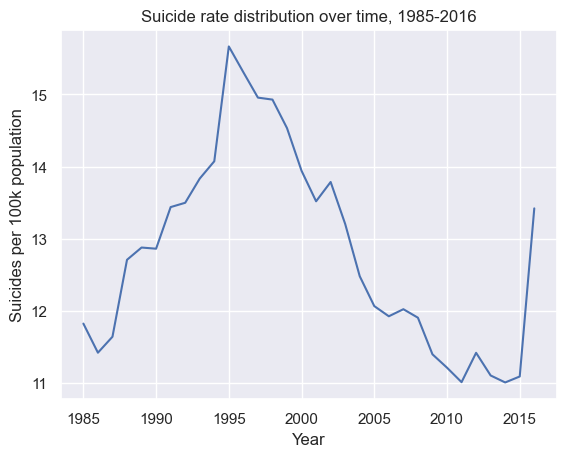

In [75]:
year_evo = raw.groupby('year')['suicides/100k pop'].mean().reset_index()
sns.set_theme()
plt.plot(year_evo['year'],year_evo['suicides/100k pop'])
plt.title("Suicide rate distribution over time, 1985-2016")
plt.xlabel('Year')
plt.ylabel('Suicides per 100k population') 
plt.show()
#The suicide rate seems to have been oscillating along time, but we do notice two peaks: one in 1995
#and another one in 2016.

We can also plot a histogram with the age group and the average rate of suicide. We first need to make an adjustment to the '5-14' value, as it does not appear correctly in the barplot.

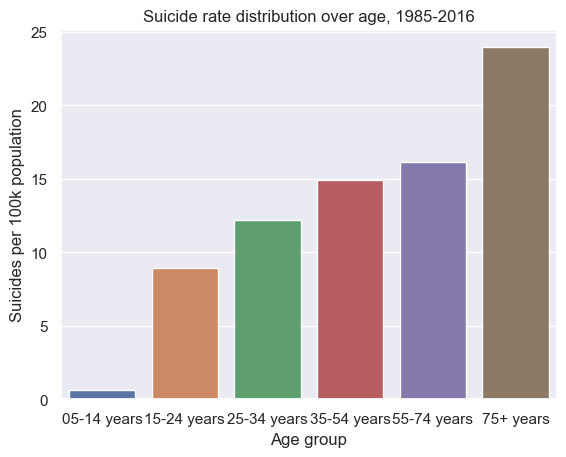

In [76]:
raw['age'] = raw['age'].apply(lambda x: '05-14 years' if x=='5-14 years' else x)
age_group_hist = raw.groupby('age')['suicides/100k pop'].mean().reset_index()
sns.set_theme()
sns.barplot(data=age_group_hist,x='age',y='suicides/100k pop')
plt.title("Suicide rate distribution over age, 1985-2016")
plt.xlabel('Age group')
plt.ylabel('Suicides per 100k population') 
plt.show()
#There is a clear trend relating age and the suicide rate. We will study this in detail later on.

It might also be interesting to have this representation separated by sex:

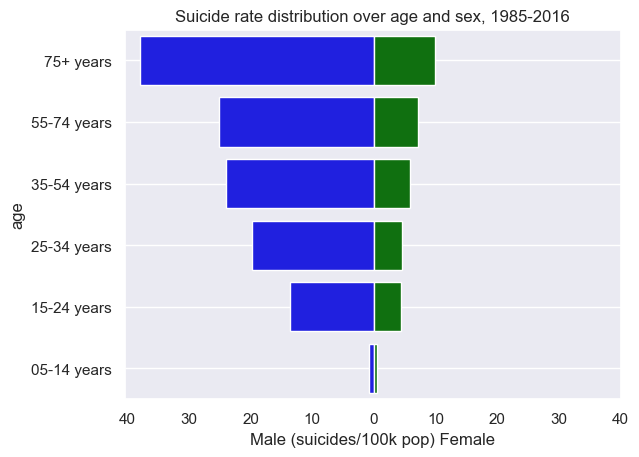

In [77]:
male_rates = raw[raw['sex']=='male'].groupby('age')['suicides/100k pop'].mean().reset_index()
fema_rates = raw[raw['sex']=='female'].groupby('age')['suicides/100k pop'].mean().reset_index()
male_rates = male_rates.rename(columns={'suicides/100k pop':'male suicides/100k pop'})
male_rates['male suicides/100k pop'] = male_rates['male suicides/100k pop']*-1.0
fema_rates = fema_rates.rename(columns={'suicides/100k pop':'female suicides/100k pop'})
joined_age_sex = male_rates.merge(right=fema_rates,on='age',how='left')
ages = ['75+ years','55-74 years','35-54 years','25-34 years','15-24 years','05-14 years']
ax1 = sns.barplot(x='male suicides/100k pop', y='age', data=joined_age_sex, order=ages, color="blue")
ax2 = sns.barplot(x='female suicides/100k pop', y='age', data=joined_age_sex, order=ages, color="green")
plt.title("Suicide rate distribution over age and sex, 1985-2016")
plt.xlabel("Male (suicides/100k pop) Female")
plt.grid()
plt.xticks(ticks=[-40,-30,-20,-10,0,10,20,30,40],
labels=['40','30','20','10','0','10','20','30','40'])
plt.show()
#we see an enormous bias here, based on sex. This will most likely be worth examining later on.

As a broader and bolder method of exploration we can just calculate and chart the correlation matrix with the raw data.

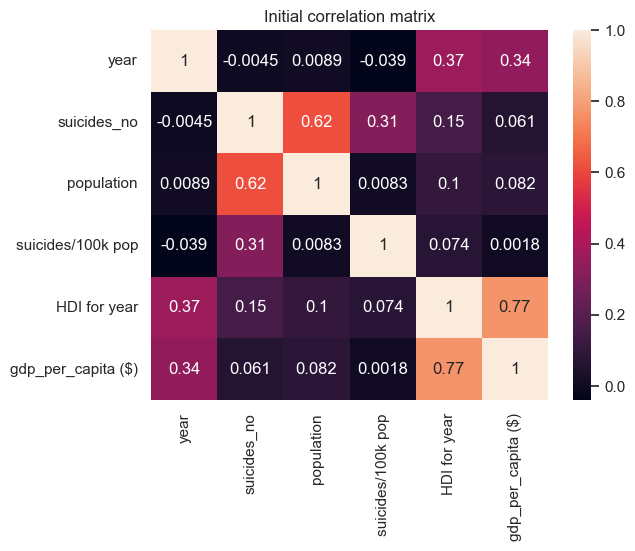

In [78]:
corr_matrix = raw.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Initial correlation matrix")
plt.show()
#we see few to no interesting values. All coefficients related to the absolute number of 
#suicides (the suicide_no) are not strongly correlated or redundant (the relative value,
#and, obviously, the population.
#we also see that variables such as the age group or the sex don't appear in this matrix.
#we'll have to clean the data in order to be able to interpret it numerically.

## Data Trimming and Cleaning
For this section we will be mainly using functions from our *clean_data.py* file.

We first trim the dataframe to only our countries of interest. This reduces the dataframe from 27820 rows to only 3452 rows.

In [79]:
eur_list = ['Russian Federation','Germany','United Kingdom','France','Italy', \
            'Spain','Ukraine','Poland','Romania','Netherlands']
raw = where_selection(df=raw,column='country',vlist=eur_list,include=True)

We will be targeting (as our dependent or *response* variable) the rate of suicides. We will now determine if any of the following columns has any null.

In [80]:
s = np.sum(raw['suicides_no'].apply(lambda x : 0 if pd.isna(x) else 1)) / len(raw['suicides_no'])
t = np.sum(raw['population'].apply(lambda x : 0 if pd.isna(x) else 1)) / len(raw['population'])
u = np.sum(raw['suicides/100k pop'].apply(lambda x : 0 if pd.isna(x) else 1)) / len(raw['suicides/100k pop'])
print(s,t,u)
#we can see that all these columns have 100% of data.

1.0 1.0 1.0


As they're all complete, we will work with the 'suicides/100k pop' column, as I believe it to better represent the relationships with all the other variables.

We should now clean up our data. We will start by removing redundant/unnecessary columns from the dataset.

In [81]:
#we will remove the following columns:
# 7: 'country-year', completely redundant with 'country' and 'year'
# 11: 'generation', as we already have 'age' and 'year'.
raw = raw.drop(columns=['country-year','generation'])

We'll now proceed to **normalize** our data, again, using methods and functions from clean_data.py.

In [82]:
#first, we make a deep copy of our dataframe, to keep the clean data untouched
wdf = raw.copy()
#we will use the lin_normalize function to normalize the following columns:
#'year','suicides_no','population','suicides/100k pop','HDI for year',
#' gdp_for_year ($) ','gdp_per_capita ($)'
cols_to_norm = ['year','suicides_no','population','suicides/100k pop', \
                'HDI for year',' gdp_for_year ($) ','gdp_per_capita ($)']
#first, unfortunately, we have to reformat a column due it's comma formatting
wdf[' gdp_for_year ($) '] = wdf[' gdp_for_year ($) '].apply( \
                            lambda x: float(x.replace(",","")))
#now we can apply the linear normalization
wdf = lin_normalize(df=wdf,columns=cols_to_norm)

For our class data, we'll just use the *class_normalize* function.

In [83]:
#regarding the sex, we can just use the class_normalize function
wdf = class_normalize(df=wdf,column='sex',mapping_order=['female','male'])

#we can do the same for the age groups
age_mapping = ['05-14 years','15-24 years','25-34 years','35-54 years',\
               '55-74 years','75+ years']
#after that we'll just normalize with the class_normalize function
wdf = class_normalize(df=wdf,column='age',mapping_order=age_mapping)

Let's see how our data looks once it's been normalized.

In [84]:
wdf.head(10)

,country,year,sex,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($)
9086,France,0.0,1.0,1.0,0.068135,0.044076,0.993159,0.303846,0.136598,0.169179
9087,France,0.0,1.0,0.8,0.105784,0.184871,0.435542,0.303846,0.136598,0.169179
9088,France,0.0,1.0,0.6,0.123198,0.287022,0.333581,0.303846,0.136598,0.169179
9089,France,0.0,1.0,0.4,0.066792,0.174712,0.290059,0.303846,0.136598,0.169179
9090,France,0.0,0.0,1.0,0.029994,0.095481,0.226838,0.303846,0.136598,0.169179
9091,France,0.0,0.0,0.8,0.054526,0.219284,0.190983,0.303846,0.136598,0.169179
9092,France,0.0,1.0,0.2,0.033127,0.179499,0.140208,0.303846,0.136598,0.169179
9093,France,0.0,0.0,0.6,0.047677,0.280558,0.131965,0.303846,0.136598,0.169179
9094,France,0.0,0.0,0.4,0.020011,0.173536,0.087455,0.303846,0.136598,0.169179
9095,France,0.0,0.0,0.2,0.008819,0.173860,0.038493,0.303846,0.136598,0.169179


## Feature selection
It is now time to decide which features to keep and which ones to discard. We can judge this based on different tests and methods.

Let us plot the correlation matrix again.

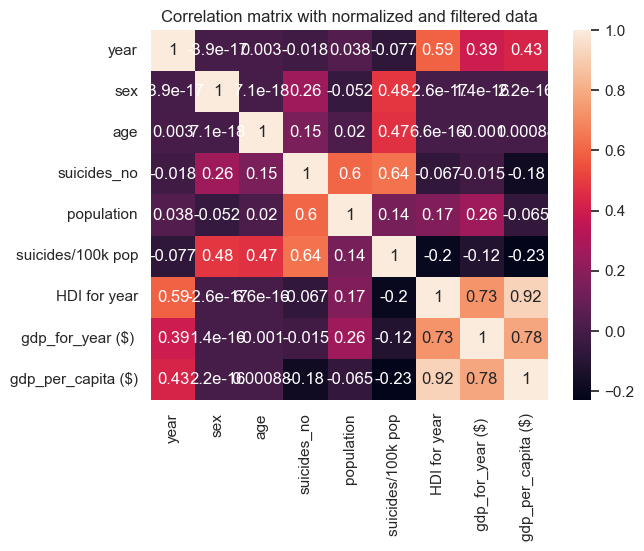

In [85]:
corr_matrix = wdf.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation matrix with normalized and filtered data")
plt.show()

We can appreciate here that both sex and age are strongly positively correlated with higher suicide rates. We also observe a decent negative correlation between the gpd per capita and the rate of suicides, same with the HDI. Let's now run a statistical t-test on the correlation matrix to see which features are meaningful.

In [86]:
cfs = corr_feature_selection(df=wdf,corr=corr_matrix,target='suicides/100k pop',threshold=0.005)
print(cfs) #TODO: fix warning!

                    suicides/100k pop    df    t-score    ts  accept
suicides_no                  0.639498  3452  48.858476  2.81    True
sex                          0.484636  3452  32.543029  2.81    True
age                          0.470863  3452  31.349765  2.81    True
gdp_per_capita ($)          -0.229213  3452 -13.831451  2.81    True
population                   0.141930  3452   8.421784  2.81    True
 gdp_for_year ($)           -0.118092  3452  -6.985189  2.81    True
HDI for year                -0.203010  1020  -6.615002  2.81    True
year                        -0.077334  3452  -4.555998  2.81    True


D:\Nero\uni\3er\Mle\KaggleCaca\kaggle-suicide-rate-study\code\generate_features.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr['t-score'] = corr[target]*np.sqrt(corr['df']-2) \
D:\Nero\uni\3er\Mle\KaggleCaca\kaggle-suicide-rate-study\code\generate_features.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr['ts'] = ts


Due to the high amount of data (thus, degrees of freedom) that the dataset posesses, the tscore is high enough to be significantly different than zero. Even so, we can clearly see that 'population', ' gdp_for_year ($) ' and 'year' don't even reach a correlation coefficient of 0.2, which is a sign strong enough by itself to consider discarding these features.

Let's see now how they test against a Lasso feature selection test. Unfortunately we'll have to skip the Country and the HDI score, as they contain non-numerical values (it's obvious for the Country, but the HDI has a high rate of NaNs).

In [87]:
twdf = wdf.drop(columns=['country','HDI for year'])
from generate_features import lasso_feature_selection
features = lasso_feature_selection(df=twdf, target='suicides/100k pop', alph=np.arange(0.005,1,0.005))
features

TypeError: lasso_feature_selection() got an unexpected keyword argument 'alph'

In [ ]:
# with open("generate_features.py",'r') as f:
#     print(f.readlines())